In [152]:
import os

from scipy import stats
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from rocketlogger.data import RocketLoggerData

import yaml
try:
    from yaml import CLoader as Loader
except ImportErorr:
    from yaml import Loader

In [153]:
# Set plot size
factor = 1.2
default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi*factor

In [154]:
def load_data(cfg, datafiles):
    """Loads csv data files and converts measurements to SI units using the defined config
    
    Parameters
    ----------
    cfg : dict
        Board configuration
    datafiles : list
        List of data files paths
        
    Returns
    -------
    pd.DataFrame
        Concatenated dataframe from all datafiles
    """
    
    df_list = []
    for d in datafiles:
        df = pd.read_csv(d)
        df_list.append(df)
    
    data = pd.concat(df_list, ignore_index=True)
    data  = df.set_index("V")
    
    data["I_in"] = data["I_in"] * 1e6
    data["I_meas"] = data["V_i"] / cfg["r_sense"] / cfg["gain"] * 1e6
    data["V_meas"] = data["V_2x"] / 2.
    
    return data

In [155]:
def load_rld(path, channel, start, stop, step):
    """Loads rocketlogger data from csv and truncates to the nearest step in the SMU.
    
    Parameters
    ----------
    path : str
        Path to rocketlogger binary data
    start : float
        Starting source value
    stop : float
        Stopping source value
    step : float
        Step source value
        
    Returns
    -------
    pd.DataFrame
        Dataframe of rocketlogger data
    """
    
    # Load RL binary data
    rld = RocketLoggerData(path)
    
    source_range = np.arange(start, stop, step)
    
    def estimate_input(x):
        """Estimate the input voltage based on measure voltage

        Parameters
        ----------
        x : float
            Inputted row

        Returns
        -------
        float
            Closest value to v_range
        """

        diff = np.abs(source_range - x)
        idx = np.argmin(diff)
        return source_range[idx]

    rld_df = pd.DataFrame(rld.get_data(), columns=rld.get_channel_names())
    rld_df["source"] = rld_df[channel].apply(estimate_input)
    rld_df["input"] = rld_df["source"]
    rld_df = rld_df.set_index("source")
    return rld_df

In [156]:
# Config file name
cfg_path = "data/config.yaml"
# Data file name
datafiles = ["data/sps3.csv"]
# Evaluation data name
evalfiles = ["data/sps3_eval.csv"]

In [157]:
# Read config
with open(cfg_path, "r") as f:
    cfg = yaml.load(f, Loader=Loader)
cfg

{'date': datetime.date(2022, 8, 24),
 'r_load': 2200,
 'r_sense': 249,
 'gain': 10,
 'ref': 'unidirectional'}

In [182]:
# SPS data
data = load_data(cfg, datafiles)
data["V_fit"] = calc_fit(data["V_meas"], data["V_in"])
data["I_fit"] = calc_fit(data["I_meas"], data["I_in"])

eval_data = load_data(cfg, evalfiles)

# RL data
rld_v = load_rld("data/rl/20220826_200050_eval_v.rld", "V1", 0.1, 1, 0.05)
rld_i = load_rld("data/rl/20220826_200050_eval_i.rld", "I1L", 45e-6, 454e-6, 22.7222e-6)
# adjust units
rld_i.index = rld_i.index * 1e6
rld_i["input"] = rld_i["input"] * 1e6
rld_i["I1L"] = rld_i["I1L"] * 1e6

In [183]:
def plot_accuracy(data):
    """Plots a graph showing the accuracy of measurements y to ideal values x
    
    Parameters
    ----------
    data : list(tuple)
        List of tuples in the format (idea, meas)
    ideal : Series
        True values
    meas : Series
        Measured values
        
    Returns
    -------
    fig, ax
        Matplotlib figure, same format as plt.subplots
    """
    
    fig, ax = plt.subplots()
    
    for (x, y) in data:
        rel = y / x
        rel = rel.groupby(level=0).describe()
        ax.errorbar(x.groupby(level=0).mean(), rel["mean"], yerr=rel["std"])
        
    ax.axhline(y=1, linestyle=':', color='k', linewidth='3')
    ax.grid()
    
    return (fig, ax)

Text(0, 0.5, 'Relative Measurement (V/V)')

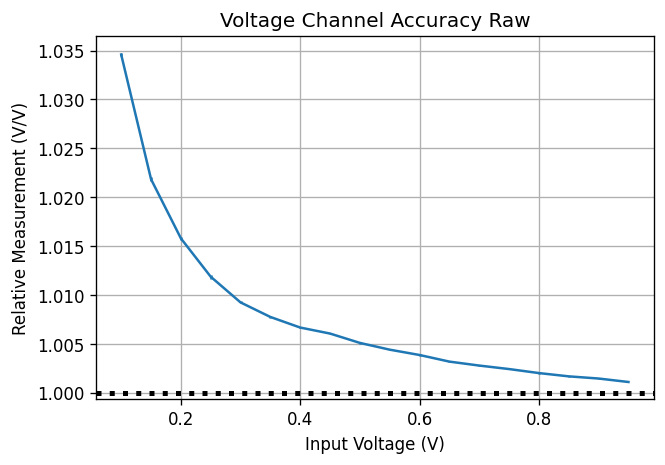

In [184]:
fig, ax = plot_accuracy([
    (data["V_in"], data["V_meas"]),

])

ax.set_title("Voltage Channel Accuracy Raw")
ax.set_xlabel("Input Voltage (V)")
ax.set_ylabel("Relative Measurement (V/V)")

Text(0, 0.5, 'Relative Measurement (A/A)')

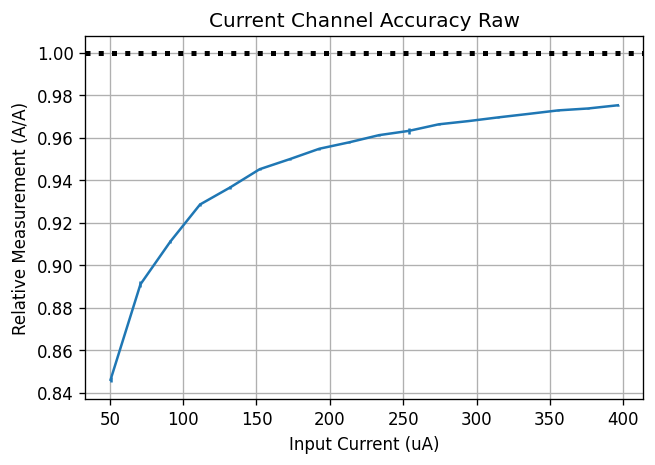

In [185]:
fig, ax = plot_accuracy([
    (data["I_in"], data["I_meas"]),
])

ax.set_title("Current Channel Accuracy Raw")
ax.set_xlabel("Input Current (uA)")
ax.set_ylabel("Relative Measurement (A/A)")

In [186]:
def calc_fit(x, y):
    """Calculates linear regression fit line given input x and output y.
    
    Parameters
    ----------
    x : Series
        input
    y : Series
        output
        
    Returns
    -------
    Series
        Fit line
    """
    
    linreg = stats.linregress(x, y)
    fit = linreg.intercept + x * linreg.slope
    return fit

Text(0, 0.5, 'Nonlinearity (V)')

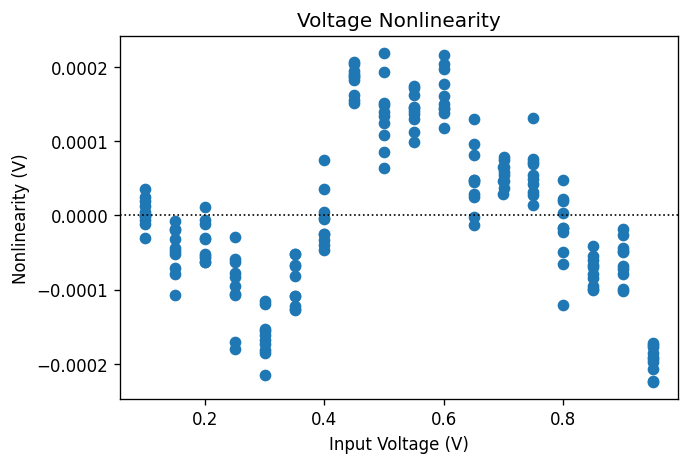

In [187]:
fig, ax = plt.subplots()
ax.scatter(data["V_in"], data["V_fit"] - data["V_in"])
ax.axhline(y=0, linestyle=':', color='k', linewidth='1')
ax.set_title("Voltage Nonlinearity")
ax.set_xlabel("Input Voltage (V)")
ax.set_ylabel("Nonlinearity (V)")

Text(0, 0.5, 'Nonlinearity (uA)')

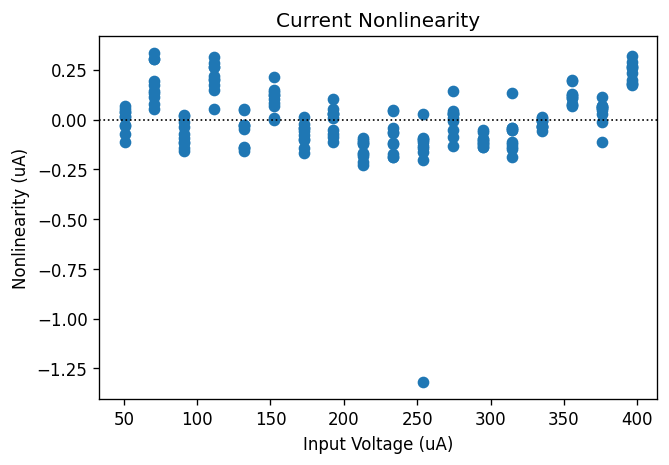

In [188]:
fig, ax = plt.subplots()
ax.scatter(data["I_in"], data["I_fit"] - data["I_in"])
ax.axhline(y=0, linestyle=':', color='k', linewidth='1')
ax.set_title("Current Nonlinearity")
ax.set_xlabel("Input Voltage (uA)")
ax.set_ylabel("Nonlinearity (uA)")

In [192]:
# Linear Regression
V_linreg = stats.linregress(data["V_meas"], data["V_in"])
I_linreg = stats.linregress(data["I_meas"], data["I_in"])

eval_data["V_fit"] = V_linreg.intercept + V_linreg.slope * eval_data["V_meas"]
eval_data["I_fit"] = I_linreg.intercept + V_linreg.slope * eval_data["I_meas"]

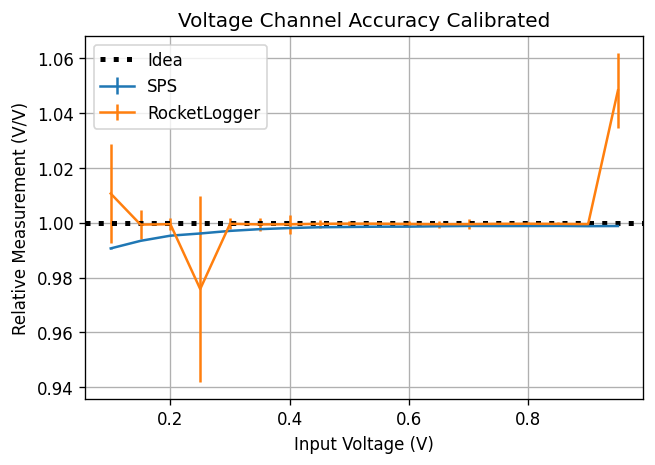

In [196]:
fig, ax = plot_accuracy([
    (eval_data["V_in"], eval_data["V_fit"]),
    (rld_v["input"], rld_v["V1"]),
])

ax.set_title("Voltage Channel Accuracy Calibrated")
ax.set_xlabel("Input Voltage (V)")
ax.set_ylabel("Relative Measurement (V/V)")
ax.legend(["Idea", "SPS", "RocketLogger"])

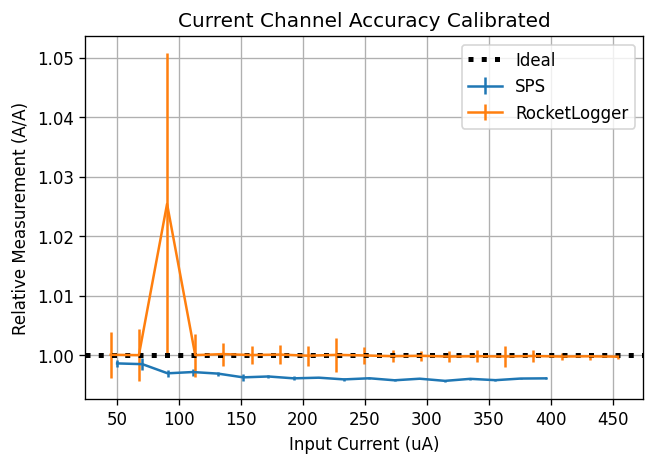

In [197]:
fig, ax = plot_accuracy([
    (eval_data["I_in"], eval_data["I_fit"]),
    (rld_i["input"], rld_i["I1L"]),
])

ax.set_title("Current Channel Accuracy Calibrated")
ax.set_xlabel("Input Current (uA)")
ax.set_ylabel("Relative Measurement (A/A)")
ax.legend(["Ideal", "SPS", "RocketLogger"])